In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler #scaling de los datos entre 0 y 1
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from os import listdir
from os.path import isfile, join
plt.style.use('seaborn')
plt.style.use('matplotlibrc.py')

Using TensorFlow backend.


In [2]:
  dic_localidades = {
        'RiesgoBariloche':'Bariloche',
        'RiesgoBuenosAires':'Buenos Aires',
        'RiesgoCABACABANA':'CABA',
        'RiesgoChacoNA':'Chaco',
        'RiesgoCórdobaCórdoba':'Córdoba',
        'RiesgoEntreRiosRíos':'Entre Ríos',
        'RiesgoJujuyJujuy':'Jujuy',
        'RiesgoLaRiojaRioja':'La Rioja',
        'RiesgoMendozaMendoza':'Mendoza',
        'RiesgoNeuquénNeuquén':'Neuquén',
        'RiesgoRioNegro':'Río Negro',
        'RiesgoSaltaSalta':'Salta',
        'RiesgoSantaCruzSantaCruz':'Santa Cruz',
        'RiesgoSantaFeSantaFe':'Santa Fe',
        'RiesgoTierradelFuegoTierradel':'Tierra del Fuego',
        'RiesgoTucumanTucuman':'Tucumán'
    }

In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [4]:
def graph_predictions(l,df_original,y_train_pr,y_test_pr,name):
    plt.plot(df_original) 
    months_tr = np.arange(l,len(y_train_pr)+l) #meses de training
    months_ts = np.arange(len(y_train_pr)+(2*l)+1,len(df_original)-1) #meses de testing
    plt.plot(months_tr,y_train_pr,label='train') #grafico de train results
    plt.plot(months_ts,y_test_pr,label='test') #grafico de test results
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días')
    plt.ylabel('Casos/100 mil hab')
    plt.legend(fontsize=14)
    plt.savefig(dic_localidades[str(name)]+'_fit_2.pdf')
    plt.show()

In [5]:
seed = 7
np.random.seed(seed)

In [6]:
mypath = 'Datos'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))] #get all file names of that path
df_train_total = [] #aca guardamos todos los datos

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
tw = 3

# armo scaler para los datos

In [8]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    df_train_total.extend(list(train_data.flatten()))

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_total = scaler.fit_transform(np.array(df_train_total).reshape(-1,1))

# ahora armo los datos de train, test y forecast

In [10]:
df_forecast = [] #aca van a estar los datos para hacer el forecasting

In [11]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast.append(df[-20:-10])
    df = df[:-20]
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    if file == 'RiesgoBariloche':
        x_train_total, y_train_total = create_dataset(train_data,tw)
        x_test_total, y_test_total = create_dataset(test_data,tw)
    else:
        #train
        x_train, y_train = create_dataset(train_data,tw)
        x_train_total = np.vstack((x_train_total,x_train))
        y_train_total = np.hstack((y_train_total,y_train))
        #test
        x_test, y_test = create_dataset(test_data,tw)
        x_test_total = np.vstack((x_test_total,x_test))
        y_test_total = np.hstack((y_test_total,y_test))
            

RiesgoBariloche
RiesgoBuenosAires
RiesgoCABACABANA
RiesgoChacoNA
RiesgoCórdobaCórdoba
RiesgoEntreRiosRíos
RiesgoJujuyJujuy
RiesgoLaRiojaRioja
RiesgoMendozaMendoza
RiesgoNeuquénNeuquén
RiesgoRioNegro
RiesgoSaltaSalta
RiesgoSantaCruzSantaCruz
RiesgoSantaFeSantaFe
RiesgoTierradelFuegoTierradel
RiesgoTucumanTucuman


In [12]:
x_train_total = x_train_total.reshape(x_train_total.shape[0],1,x_train_total.shape[1])
x_test_total = x_test_total.reshape(x_test_total.shape[0],1,x_test_total.shape[1])

In [13]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=128,activation='relu',return_sequences=True,input_shape=(1,tw)))
model.add(keras.layers.LSTM(units=128,activation='relu'))
model.add(keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss=keras.losses.MSE,metrics=['mse']) 
model.summary()
history = model.fit(x_train_total, y_train_total,epochs=1000,batch_size=256,validation_data=(x_test_total,y_test_total),verbose=2) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            67584     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________
Train on 3478 samples, validate on 830 samples
Epoch 1/1000
 - 1s - loss: 0.0455 - mse: 0.0455 - val_loss: 0.8902 - val_mse: 0.8902
Epoch 2/1000
 - 0s - loss: 0.0359 - mse: 0.0359 - val_loss: 0.6549 - val_mse: 0.6549
Epoch 3/1000
 - 0s - loss: 0.0258 - mse: 0.0258 - val_loss: 0.2647 - val_mse: 0.2647
Epoch 4/1000
 - 0s - loss: 0.0125 - mse: 0.0125 - val_loss: 0.1424 - val_mse

Epoch 81/1000
 - 0s - loss: 6.2667e-05 - mse: 6.2667e-05 - val_loss: 0.0114 - val_mse: 0.0114
Epoch 82/1000
 - 0s - loss: 5.9720e-05 - mse: 5.9720e-05 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 83/1000
 - 0s - loss: 5.6506e-05 - mse: 5.6506e-05 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 84/1000
 - 0s - loss: 5.5568e-05 - mse: 5.5568e-05 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 85/1000
 - 0s - loss: 5.7081e-05 - mse: 5.7081e-05 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 86/1000
 - 0s - loss: 5.3700e-05 - mse: 5.3700e-05 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 87/1000
 - 0s - loss: 4.7652e-05 - mse: 4.7652e-05 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 88/1000
 - 0s - loss: 4.5341e-05 - mse: 4.5341e-05 - val_loss: 0.0100 - val_mse: 0.0100
Epoch 89/1000
 - 0s - loss: 4.3357e-05 - mse: 4.3357e-05 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 90/1000
 - 0s - loss: 4.8040e-05 - mse: 4.8040e-05 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 91/1000
 - 0s - loss: 4.2795e-05 - mse: 4.2795e-05 - v

Epoch 168/1000
 - 0s - loss: 1.4851e-05 - mse: 1.4851e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 169/1000
 - 0s - loss: 1.3711e-05 - mse: 1.3711e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 170/1000
 - 0s - loss: 1.3246e-05 - mse: 1.3246e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 171/1000
 - 0s - loss: 1.3536e-05 - mse: 1.3536e-05 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 172/1000
 - 0s - loss: 1.3210e-05 - mse: 1.3210e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 173/1000
 - 0s - loss: 1.3615e-05 - mse: 1.3615e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 174/1000
 - 0s - loss: 1.3601e-05 - mse: 1.3601e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 175/1000
 - 0s - loss: 1.3487e-05 - mse: 1.3487e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 176/1000
 - 0s - loss: 1.3798e-05 - mse: 1.3798e-05 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 177/1000
 - 0s - loss: 1.3947e-05 - mse: 1.3947e-05 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 178/1000
 - 0s - loss: 1.6398e-05 - mse: 1.6

Epoch 255/1000
 - 0s - loss: 1.3709e-05 - mse: 1.3709e-05 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 256/1000
 - 0s - loss: 1.4250e-05 - mse: 1.4250e-05 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 257/1000
 - 0s - loss: 1.3774e-05 - mse: 1.3774e-05 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 258/1000
 - 0s - loss: 1.4153e-05 - mse: 1.4153e-05 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 259/1000
 - 0s - loss: 1.4004e-05 - mse: 1.4004e-05 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 260/1000
 - 0s - loss: 1.2987e-05 - mse: 1.2987e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 261/1000
 - 0s - loss: 1.5082e-05 - mse: 1.5082e-05 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 262/1000
 - 0s - loss: 1.2730e-05 - mse: 1.2730e-05 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 263/1000
 - 0s - loss: 1.2648e-05 - mse: 1.2648e-05 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 264/1000
 - 0s - loss: 1.3698e-05 - mse: 1.3698e-05 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 265/1000
 - 0s - loss: 1.4112e-05 - mse: 1.4

Epoch 342/1000
 - 0s - loss: 1.2798e-05 - mse: 1.2798e-05 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 343/1000
 - 0s - loss: 1.2988e-05 - mse: 1.2988e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 344/1000
 - 0s - loss: 1.1863e-05 - mse: 1.1863e-05 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 345/1000
 - 0s - loss: 1.2345e-05 - mse: 1.2345e-05 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 346/1000
 - 0s - loss: 1.1849e-05 - mse: 1.1849e-05 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 347/1000
 - 0s - loss: 1.2290e-05 - mse: 1.2290e-05 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 348/1000
 - 0s - loss: 1.5382e-05 - mse: 1.5382e-05 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 349/1000
 - 0s - loss: 1.5820e-05 - mse: 1.5820e-05 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 350/1000
 - 0s - loss: 1.2909e-05 - mse: 1.2909e-05 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 351/1000
 - 0s - loss: 1.2164e-05 - mse: 1.2164e-05 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 352/1000
 - 0s - loss: 1.3263e-05 - mse: 1.3

Epoch 429/1000
 - 0s - loss: 1.2597e-05 - mse: 1.2597e-05 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 430/1000
 - 0s - loss: 1.5946e-05 - mse: 1.5946e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 431/1000
 - 0s - loss: 1.3289e-05 - mse: 1.3289e-05 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 432/1000
 - 0s - loss: 1.2261e-05 - mse: 1.2261e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 433/1000
 - 0s - loss: 1.3742e-05 - mse: 1.3742e-05 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 434/1000
 - 0s - loss: 1.3323e-05 - mse: 1.3323e-05 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 435/1000
 - 0s - loss: 1.2664e-05 - mse: 1.2664e-05 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 436/1000
 - 0s - loss: 1.2195e-05 - mse: 1.2195e-05 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 437/1000
 - 0s - loss: 1.6206e-05 - mse: 1.6206e-05 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 438/1000
 - 0s - loss: 1.7497e-05 - mse: 1.7497e-05 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 439/1000
 - 0s - loss: 1.3880e-05 - mse: 1.3

Epoch 516/1000
 - 0s - loss: 1.2021e-05 - mse: 1.2021e-05 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 517/1000
 - 0s - loss: 1.1868e-05 - mse: 1.1868e-05 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 518/1000
 - 0s - loss: 1.3779e-05 - mse: 1.3779e-05 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 519/1000
 - 0s - loss: 1.2375e-05 - mse: 1.2375e-05 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 520/1000
 - 0s - loss: 1.1830e-05 - mse: 1.1830e-05 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 521/1000
 - 0s - loss: 1.1338e-05 - mse: 1.1338e-05 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 522/1000
 - 0s - loss: 1.2384e-05 - mse: 1.2384e-05 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 523/1000
 - 0s - loss: 1.2681e-05 - mse: 1.2681e-05 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 524/1000
 - 0s - loss: 1.1646e-05 - mse: 1.1646e-05 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 525/1000
 - 0s - loss: 1.2363e-05 - mse: 1.2363e-05 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 526/1000
 - 0s - loss: 1.3698e-05 - mse: 1.3

Epoch 603/1000
 - 0s - loss: 1.2280e-05 - mse: 1.2280e-05 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 604/1000
 - 0s - loss: 1.2838e-05 - mse: 1.2838e-05 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 605/1000
 - 0s - loss: 1.1831e-05 - mse: 1.1831e-05 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 606/1000
 - 0s - loss: 1.3421e-05 - mse: 1.3421e-05 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 607/1000
 - 0s - loss: 1.2035e-05 - mse: 1.2035e-05 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 608/1000
 - 0s - loss: 1.2433e-05 - mse: 1.2433e-05 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 609/1000
 - 0s - loss: 1.1874e-05 - mse: 1.1874e-05 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 610/1000
 - 0s - loss: 1.4475e-05 - mse: 1.4475e-05 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 611/1000
 - 0s - loss: 1.3990e-05 - mse: 1.3990e-05 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 612/1000
 - 0s - loss: 1.3662e-05 - mse: 1.3662e-05 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 613/1000
 - 0s - loss: 1.1726e-05 - mse: 1.1

Epoch 690/1000
 - 0s - loss: 1.1498e-05 - mse: 1.1498e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 691/1000
 - 0s - loss: 1.2146e-05 - mse: 1.2146e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 692/1000
 - 0s - loss: 1.5698e-05 - mse: 1.5698e-05 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 693/1000
 - 0s - loss: 1.2044e-05 - mse: 1.2044e-05 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 694/1000
 - 0s - loss: 1.2076e-05 - mse: 1.2076e-05 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 695/1000
 - 0s - loss: 1.4073e-05 - mse: 1.4073e-05 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 696/1000
 - 0s - loss: 1.3909e-05 - mse: 1.3909e-05 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 697/1000
 - 0s - loss: 1.2174e-05 - mse: 1.2174e-05 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 698/1000
 - 0s - loss: 1.2614e-05 - mse: 1.2614e-05 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 699/1000
 - 0s - loss: 1.2381e-05 - mse: 1.2381e-05 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 700/1000
 - 0s - loss: 1.4003e-05 - mse: 1.4

Epoch 777/1000
 - 0s - loss: 1.2133e-05 - mse: 1.2133e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 778/1000
 - 0s - loss: 1.3451e-05 - mse: 1.3451e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 779/1000
 - 0s - loss: 1.3146e-05 - mse: 1.3146e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 780/1000
 - 0s - loss: 1.2161e-05 - mse: 1.2161e-05 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 781/1000
 - 0s - loss: 1.4373e-05 - mse: 1.4373e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 782/1000
 - 0s - loss: 1.2042e-05 - mse: 1.2042e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 783/1000
 - 0s - loss: 1.2395e-05 - mse: 1.2395e-05 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 784/1000
 - 0s - loss: 1.4677e-05 - mse: 1.4677e-05 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 785/1000
 - 0s - loss: 1.5604e-05 - mse: 1.5604e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 786/1000
 - 0s - loss: 1.2491e-05 - mse: 1.2491e-05 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 787/1000
 - 0s - loss: 1.1698e-05 - mse: 1.1

Epoch 860/1000
 - 0s - loss: 1.2922e-05 - mse: 1.2922e-05 - val_loss: 7.3934e-04 - val_mse: 7.3934e-04
Epoch 861/1000
 - 0s - loss: 1.2025e-05 - mse: 1.2025e-05 - val_loss: 7.4553e-04 - val_mse: 7.4553e-04
Epoch 862/1000
 - 0s - loss: 1.2920e-05 - mse: 1.2920e-05 - val_loss: 7.5124e-04 - val_mse: 7.5124e-04
Epoch 863/1000
 - 0s - loss: 1.3583e-05 - mse: 1.3583e-05 - val_loss: 7.6543e-04 - val_mse: 7.6543e-04
Epoch 864/1000
 - 0s - loss: 1.1542e-05 - mse: 1.1542e-05 - val_loss: 7.2433e-04 - val_mse: 7.2433e-04
Epoch 865/1000
 - 0s - loss: 1.1193e-05 - mse: 1.1193e-05 - val_loss: 7.3626e-04 - val_mse: 7.3626e-04
Epoch 866/1000
 - 0s - loss: 1.1642e-05 - mse: 1.1642e-05 - val_loss: 7.2369e-04 - val_mse: 7.2369e-04
Epoch 867/1000
 - 0s - loss: 1.1427e-05 - mse: 1.1427e-05 - val_loss: 7.2391e-04 - val_mse: 7.2391e-04
Epoch 868/1000
 - 0s - loss: 1.1347e-05 - mse: 1.1347e-05 - val_loss: 7.2179e-04 - val_mse: 7.2179e-04
Epoch 869/1000
 - 0s - loss: 1.1703e-05 - mse: 1.1703e-05 - val_loss: 7.6

Epoch 940/1000
 - 0s - loss: 1.3462e-05 - mse: 1.3462e-05 - val_loss: 7.2907e-04 - val_mse: 7.2907e-04
Epoch 941/1000
 - 0s - loss: 1.2786e-05 - mse: 1.2786e-05 - val_loss: 7.8392e-04 - val_mse: 7.8392e-04
Epoch 942/1000
 - 0s - loss: 1.2016e-05 - mse: 1.2016e-05 - val_loss: 7.2091e-04 - val_mse: 7.2091e-04
Epoch 943/1000
 - 0s - loss: 1.3470e-05 - mse: 1.3470e-05 - val_loss: 8.0154e-04 - val_mse: 8.0154e-04
Epoch 944/1000
 - 0s - loss: 1.4443e-05 - mse: 1.4443e-05 - val_loss: 8.0965e-04 - val_mse: 8.0965e-04
Epoch 945/1000
 - 0s - loss: 1.4427e-05 - mse: 1.4427e-05 - val_loss: 6.5075e-04 - val_mse: 6.5075e-04
Epoch 946/1000
 - 0s - loss: 1.2683e-05 - mse: 1.2683e-05 - val_loss: 7.9591e-04 - val_mse: 7.9591e-04
Epoch 947/1000
 - 0s - loss: 1.1371e-05 - mse: 1.1371e-05 - val_loss: 7.8910e-04 - val_mse: 7.8910e-04
Epoch 948/1000
 - 0s - loss: 1.1236e-05 - mse: 1.1236e-05 - val_loss: 9.2839e-04 - val_mse: 9.2839e-04
Epoch 949/1000
 - 0s - loss: 1.2708e-05 - mse: 1.2708e-05 - val_loss: 6.9

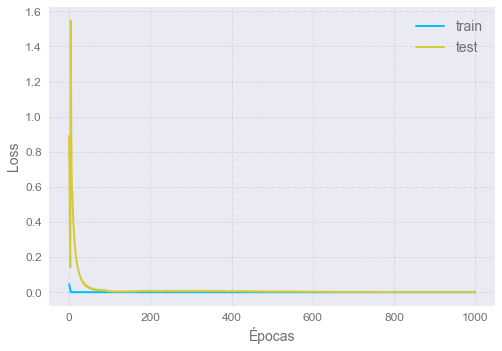

In [14]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend(fontsize=14)

In [15]:
y_train_pr = model.predict(x_train_total)
y_test_pr = model.predict(x_test_total)
y_train_pr = scaler.inverse_transform(y_train_pr.reshape(-1,1))
y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
y_test =  scaler.inverse_transform(y_test_total.reshape(-1,1))
y_train = scaler.inverse_transform(y_train_total.reshape(-1,1))
print('train mse squared:',mean_squared_error(y_train_pr,y_train)) 
print('test mse squared:',mean_squared_error(y_test_pr,y_test)) 

train mse squared: 5.594786808782728
test mse squared: 332.30361170699354


# veo como se ajustan a los train y test data para distintas localidades

In [21]:
def forecast(test_data_scaled,df1,name):
    n = len(test_data_scaled)
    lag = tw
    x_input=test_data_scaled[n-lag:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    lst_output=[]
    n_steps=lag
    i=0

    while(i<10): 
        if(len(temp_input)>lag):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, 1, lag))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, 1, lag))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
    
    lst_output = scaler.inverse_transform(lst_output)
    plt.plot(lst_output,'o',label='forecast')
    plt.plot(df1,label='true data')
    plt.title(dic_localidades[str(name)])
    plt.xlabel('Días posteriores')
    plt.ylabel('Casos/100mil hab')
    plt.legend(fontsize=14)
    plt.savefig(dic_localidades[str(name)]+'_forecast_2.pdf')
    print('forecast error:',sum((lst_output-df_forecast)**2))
    plt.show()

RiesgoBariloche
train rmse: 15.036188211018708
test rmse: 55.82160586828702
train mape: 0.9984065101605467
test mape: 0.9903228688725028
train mae: 2.5457887060278455
test mae: 5.961686772118994


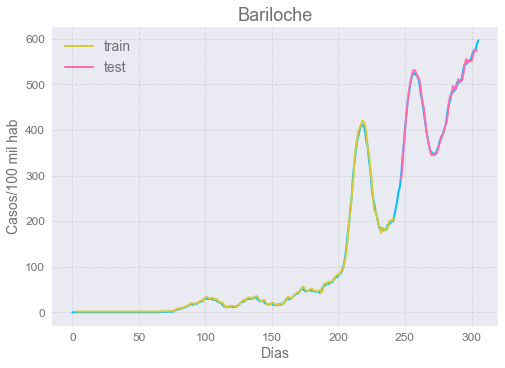

forecast error: [62424.58423944]


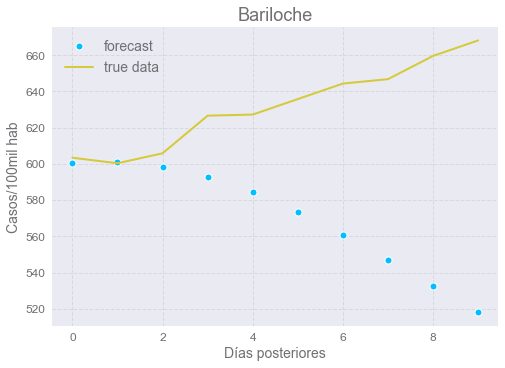

RiesgoBuenosAires
train rmse: 4.27463862208985
test rmse: 10.892204665023941
train mape: 0.9997737924194154
test mape: 0.9964243161606376
train mae: 1.706636850447323
test mae: 2.780936352229313


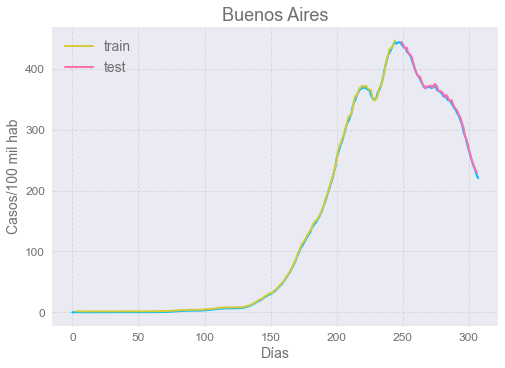

forecast error: [20854.62175649]


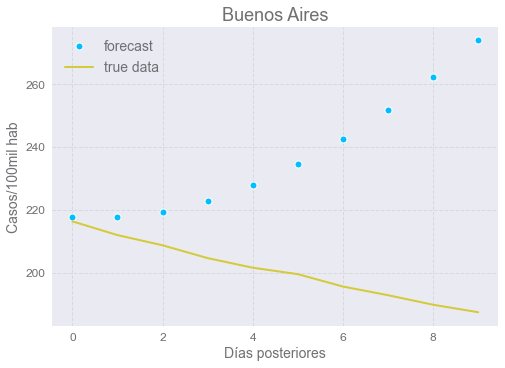

RiesgoCABACABANA
train rmse: 4.23944514926144
test rmse: 7.876669270220866
train mape: 0.9999090508751018
test mape: 0.9990435480342872
train mae: 1.6685765186705641
test mae: 2.3503255378268957


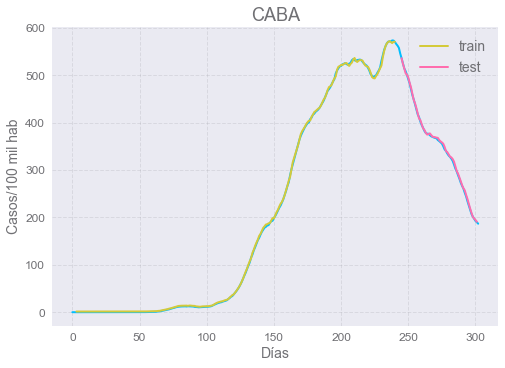

forecast error: [18425.51774748]


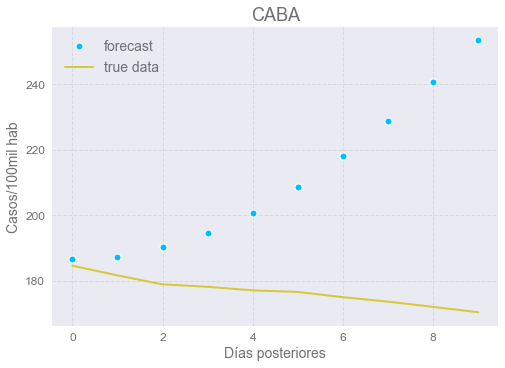

RiesgoChacoNA
train rmse: 3.9718378736608284
test rmse: 13.668739236649614
train mape: 0.9959102411464397
test mape: 0.9899219773105163
train mae: 1.7487608517440922
test mae: 3.1104884759436113


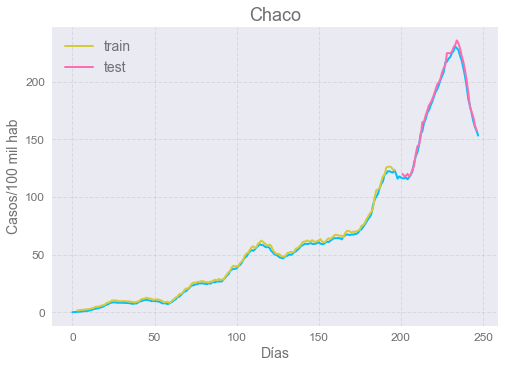

forecast error: [250.06713603]


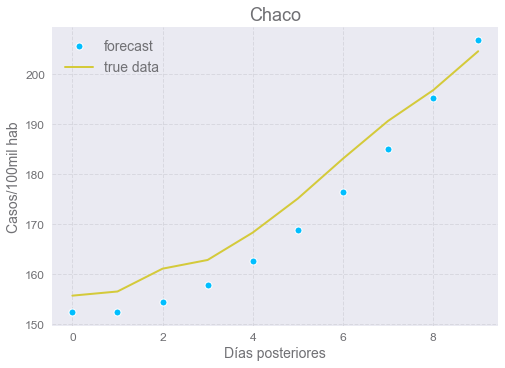

RiesgoCórdobaCórdoba
train rmse: 2.081765128590699
test rmse: 27.75339518933239
train mape: 0.997342113340321
test mape: 0.9990250067488308
train mae: 1.4019505273925663
test mae: 4.164351218770021


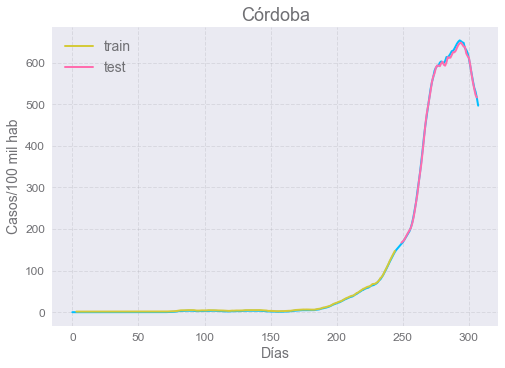

forecast error: [1331.78817962]


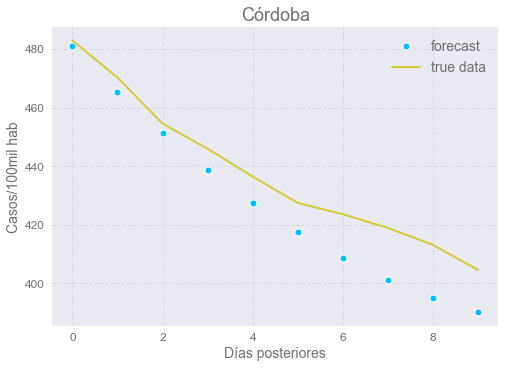

RiesgoEntreRiosRíos
train rmse: 3.0668931112902076
test rmse: 13.122671746991667
train mape: 0.9980438296438021
test mape: 0.998063929511529
train mae: 1.529025960935742
test mae: 2.8763228054250987


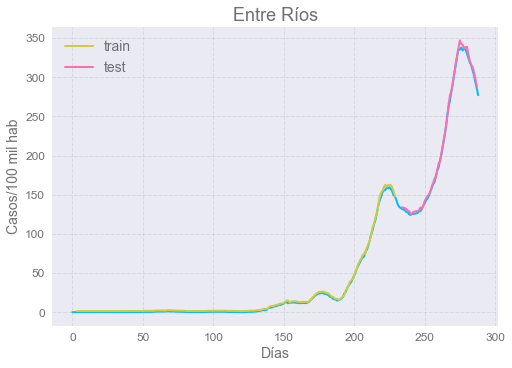

forecast error: [1296.44851921]


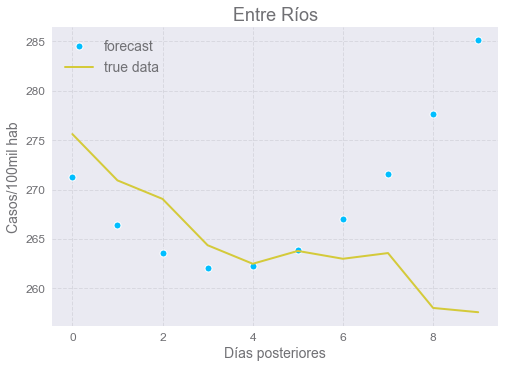

RiesgoJujuyJujuy
train rmse: 6.902329736433996
test rmse: 13.916895505796257
train mape: 0.9997487855236609
test mape: 0.998810241682318
train mae: 1.9914975283481569
test mae: 3.030854438396362


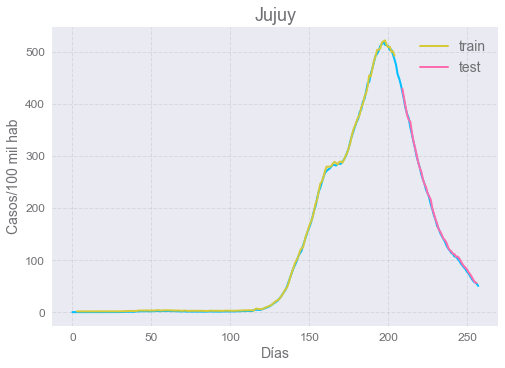

forecast error: [7842.73708172]


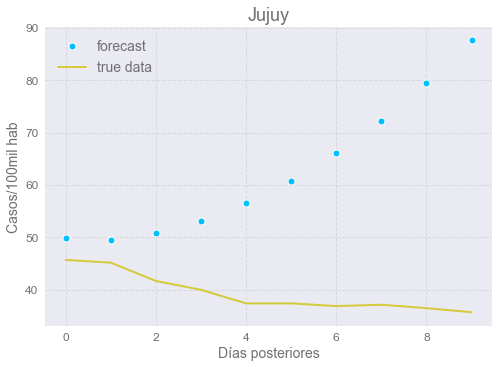

RiesgoLaRiojaRioja
train rmse: 4.67271576445478
test rmse: 45.890377015803736
train mape: 0.9991243879716031
test mape: 0.9898898652351534
train mae: 1.741151915000017
test mae: 5.302807693617377


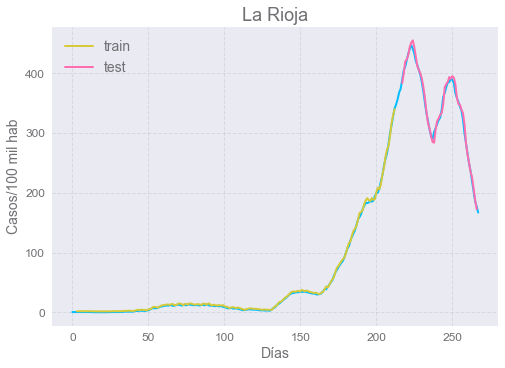

forecast error: [16829.01797129]


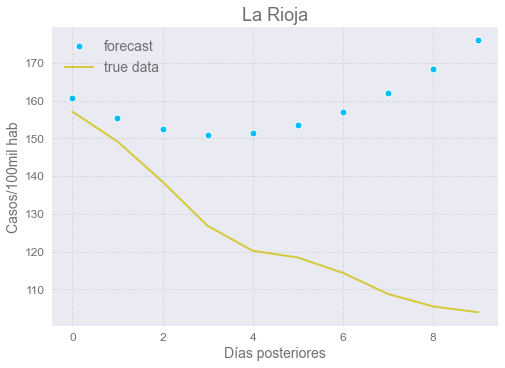

RiesgoMendozaMendoza
train rmse: 2.4645602144144636
test rmse: 14.633195824165371
train mape: 0.9997411764975068
test mape: 0.9914657547806012
train mae: 1.4195251161763887
test mae: 3.195479762778589


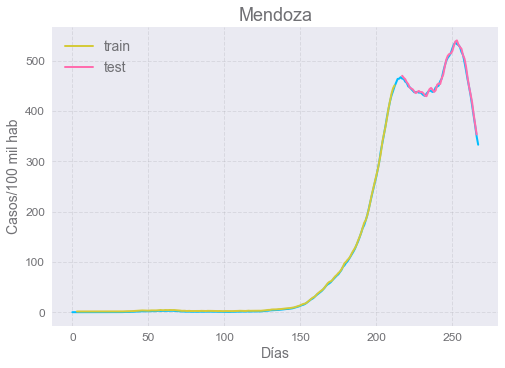

forecast error: [4800.3586551]


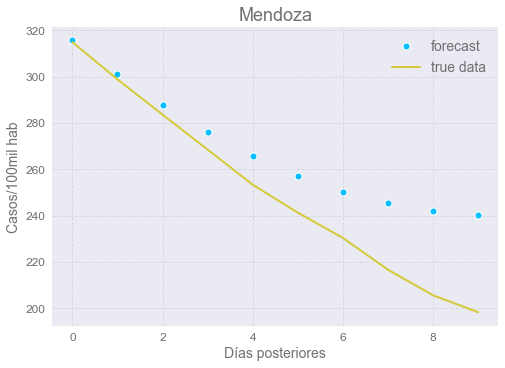

RiesgoNeuquénNeuquén
train rmse: 4.075496177571586
test rmse: 561.0261204018801
train mape: 0.9995758045789549
test mape: 0.9627230377783188
train mae: 1.6725552752481467
test mae: 20.507244484953528


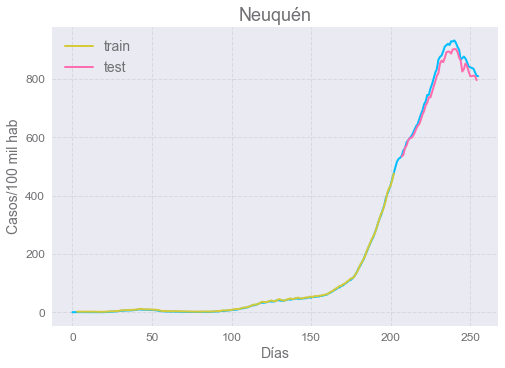

forecast error: [267659.11818715]


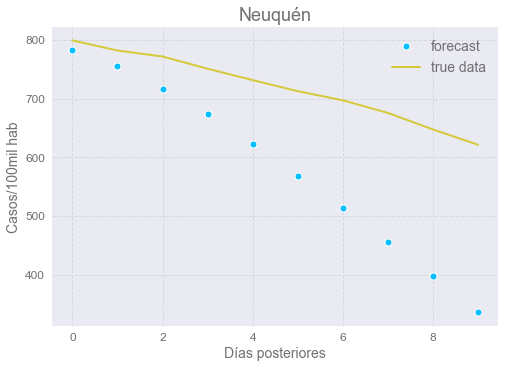

RiesgoRioNegro
train rmse: 4.9486536415940625
test rmse: 101.05759019090414
train mape: 0.9992793507101014
test mape: 0.9929974807774183
train mae: 1.7361439212438374
test mae: 7.546352874460634


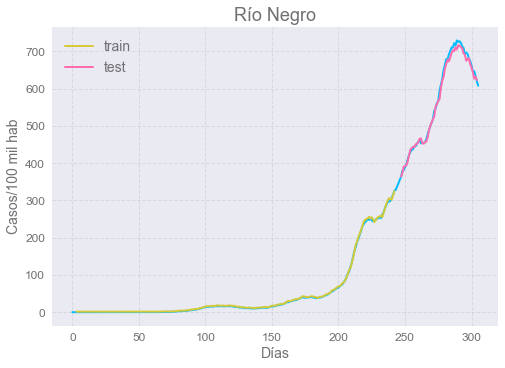

forecast error: [26764.14442296]


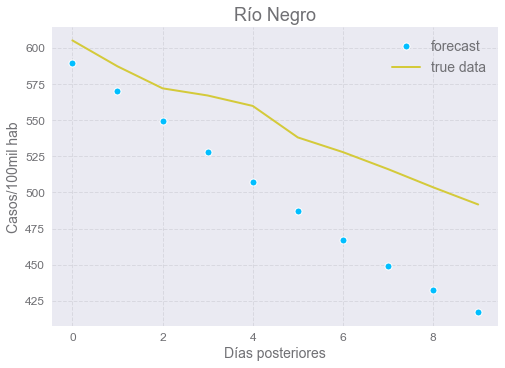

RiesgoSaltaSalta
train rmse: 2.740711866572609
test rmse: 19.892115737517987
train mape: 0.9994792917074772
test mape: 0.9959886366551017
train mae: 1.4897876541578847
test mae: 3.6404244391071696


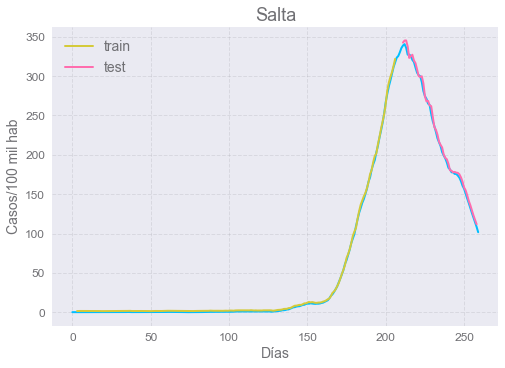

forecast error: [10983.28029606]


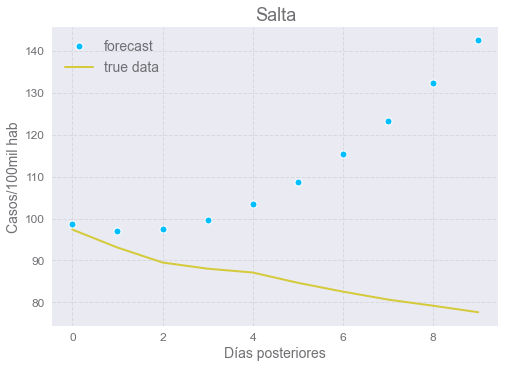

RiesgoSantaCruzSantaCruz
train rmse: 11.363827982004464
test rmse: 69.76863728980423
train mape: 0.9988459378987186
test mape: 0.9932263497033488
train mae: 2.270406483601814
test mae: 6.395931624214509


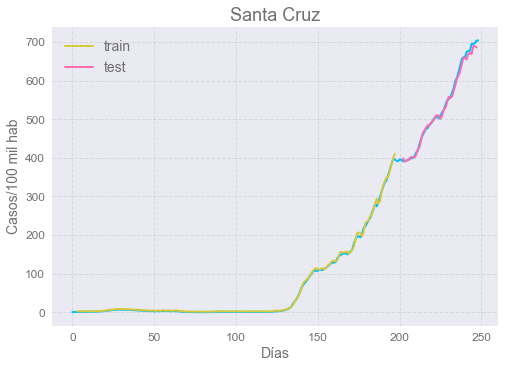

forecast error: [315257.88132117]


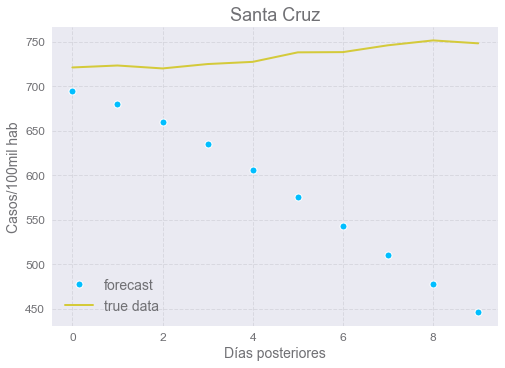

RiesgoSantaFeSantaFe
train rmse: 2.208113193130625
test rmse: 329.16380334208674
train mape: 0.9996851465532219
test mape: 0.9764779553288
train mae: 1.3989278657846265
test mae: 15.86586706990176


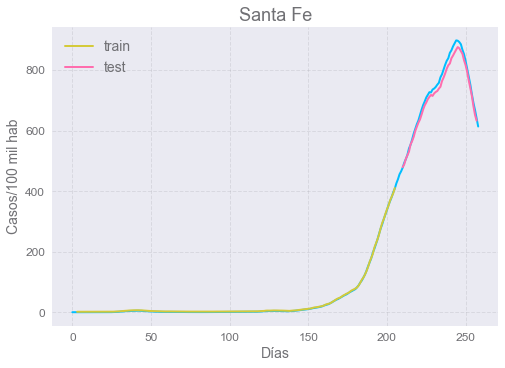

forecast error: [116979.42146819]


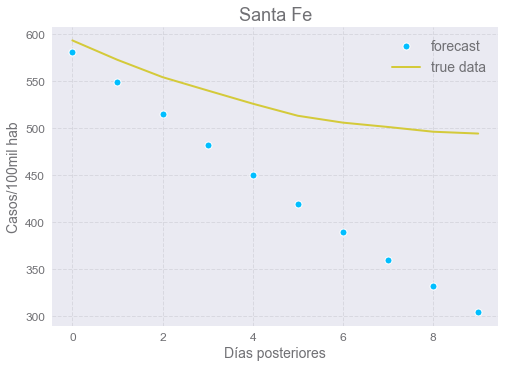

RiesgoTierradelFuegoTierradel
train rmse: 13.670428969572434
test rmse: 3299.5478235829414
train mape: 0.9995235059086481
test mape: 0.9914293436672866
train mae: 2.4828871424339454
test mae: 43.032833530722776


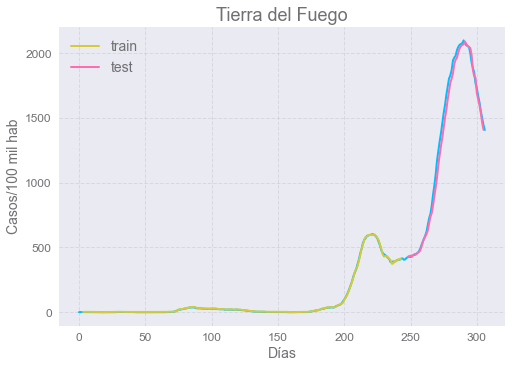

forecast error: [5521488.61395998]


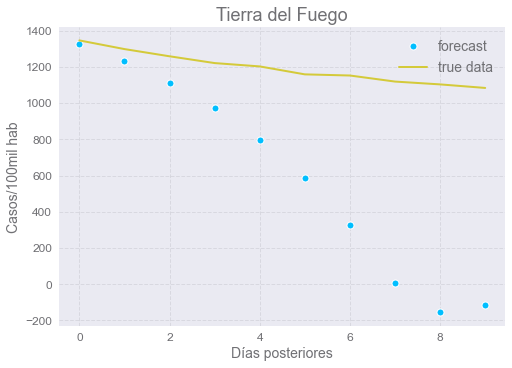

RiesgoTucumanTucuman
train rmse: 2.2225128807605787
test rmse: 460.53247517143956
train mape: 0.9997028657854192
test mape: 0.9857714726122332
train mae: 1.3565266233362165
test mae: 18.35829496929627


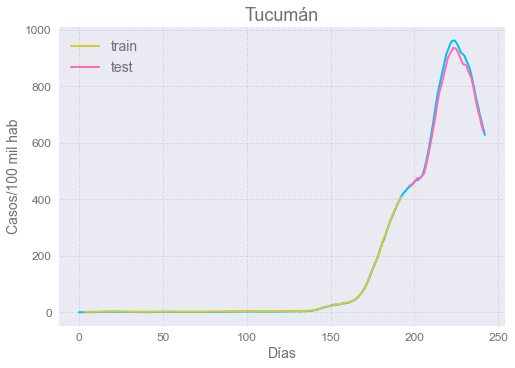

forecast error: [155321.86875339]


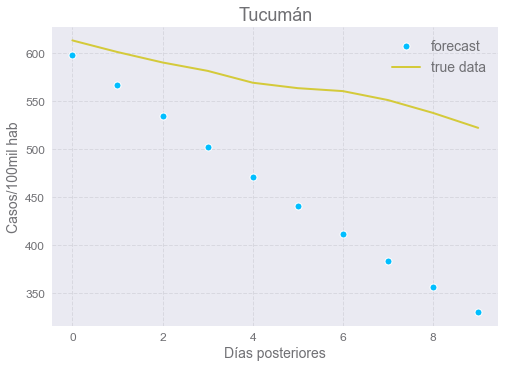

In [22]:
for file in files:
    print(file)
    data = pd.read_csv(mypath+str('/')+file,sep=",",quotechar='"',na_values=[''])
    data = data["incidenciaAcum14d"]
    df = pd.DataFrame(data)
    df = df.to_numpy()
    df_forecast = df[-20:-10]
    df = df[:-20]
    df_original = np.copy(df)
    total_size = df.shape[0]
    train_size = int(0.8*total_size)
    test_size = total_size - train_size
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    train_data = scaler.transform(train_data.reshape(-1,1))
    test_data = scaler.transform(test_data.reshape(-1,1))
    #train
    x_train, y_train = create_dataset(train_data,tw)
    #test
    x_test, y_test = create_dataset(test_data,tw)
    x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    x_test= x_test.reshape(x_test.shape[0],1,x_test.shape[1])
    y_train_pr = model.predict(x_train)
    y_test_pr = model.predict(x_test)
    y_train_pr = scaler.inverse_transform(y_train_pr.reshape(-1,1))
    y_test_pr = scaler.inverse_transform(y_test_pr.reshape(-1,1))
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    #imprimo mse para train y test
    print('train rmse:',mean_squared_error(y_train,y_train_pr)) 
    print('test rmse:',mean_squared_error(y_test,y_test_pr))
    #imprimo r2
    print('train mape:',r2_score(y_train,y_train_pr)) 
    print('test mape:',r2_score(y_test,y_test_pr)) 
    #imprimo mae
    print('train mae:',mean_absolute_error(y_train,y_train_pr)) 
    print('test mae:',mean_absolute_error(y_test,y_test_pr)) 
    graph_predictions(tw,df_original,y_train_pr,y_test_pr,file)
    forecast(test_data,df_forecast,file)